In [2]:
import pandas as pd 
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report

## Data Collection & Merging

In [3]:
data = pd.read_csv('./data/uncleaned_data.csv')
data.head()

,Unnamed: 0.1,name,club_x,injuries,Unnamed: 0,nationality,position,club_y,age,birth_year,...,touches_live_ball,dribbles,miscontrols,dispossessed,passes_received,fouls,fouled,ball_recoveries,aerials_won,"aerials_lost,"
0,0,Ederson,Manchester City,"[('20/21', 'Virus Infection', 'Dec 27, 2020', ...",689,br BRA,GK,Manchester City,29-100,1993,...,547.0,0.0,0.0,0.0,345.0,0.0,2.0,19.0,3.0,"0.0,"
1,1,Rúben Dias,Manchester City,"[('21/22', 'Knock', 'Mar 3, 2022', 'Apr 11, 20...",615,pt POR,DF,Manchester City,25-195,1997,...,972.0,3.0,0.0,0.0,762.0,10.0,3.0,41.0,26.0,"13.0,"
2,2,Aymeric Laporte,Manchester City,"[('22/23', 'Knee Surgery', 'Jun 30, 2022', 'Oc...",1232,es ESP,DF,Manchester City,28-182,1994,...,279.0,2.0,1.0,0.0,216.0,0.0,2.0,11.0,11.0,"4.0,"
3,3,John Stones,Manchester City,"[('22/23', 'Hamstring Injury', 'Sep 26, 2022',...",2101,eng ENG,DF,Manchester City,28-181,1994,...,686.0,5.0,3.0,1.0,541.0,3.0,3.0,37.0,10.0,"6.0,"
4,4,Nathan Aké,Manchester City,"[('20/21', 'Hamstring Injury', 'Dec 27, 2020',...",37,nl NED,DF,Manchester City,27-280,1995,...,648.0,0.0,3.0,0.0,538.0,2.0,4.0,24.0,13.0,"10.0,"


In [4]:
ratings_data = pd.read_csv('./data/final_ratings.csv')
ratings_data.head()

,FC 25,FC 24,Name,FIFA 23,FIFA 22,FIFA 21,FIFA 20,FIFA 19,FIFA 18,FIFA 17,FIFA 16,FIFA 15,FIFA 14/25,FIFA 13,FIFA 12,FIFA 11,FIFA 10,FIFA 09,FIFA 08,FIFA 07
0,80.0,77.0,ederson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,88.0,89.0,rúben-dias,88.0,87.0,81.0,80.0,78.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,83.0,85.0,aymeric-laporte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,85.0,85.0,john-stones,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84.0,81.0,nathan-aké,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
ratings_data = ratings_data.rename(columns={'Name': 'name'})

In [6]:
def normalize_name(name):
    return (
        str(name)
        .strip()
        .lower()
        .replace(' ', '-')
        .replace("'", '')
        .replace("é", 'e')
        .replace("á", 'a')
        .replace("ó", 'o')
        .replace("ú", 'u')
        .replace("í", 'i')
        .replace("ç", 'c')
    )

# Apply normalization to both datasets before the merge
data['name'] = data['name'].apply(normalize_name)
ratings_data['name'] = ratings_data['name'].apply(normalize_name)

In [7]:
merged_data = pd.merge(data, ratings_data, on='name', how='outer')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1927 entries, 0 to 1926
Data columns (total 71 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0.1                 1926 non-null   float64
 1   name                         1927 non-null   object 
 2   club_x                       1926 non-null   object 
 3   injuries                     1926 non-null   object 
 4   Unnamed: 0                   1926 non-null   float64
 5   nationality                  1926 non-null   object 
 6   position                     1926 non-null   object 
 7   club_y                       1926 non-null   object 
 8   age                          1926 non-null   object 
 9   birth_year                   1926 non-null   float64
 10  games                        1926 non-null   float64
 11  games_starts                 1926 non-null   float64
 12  minutes                      1926 non-null   float64
 13  cards_yellow      

In [8]:
# Keep flattened injuries where they exist
parsed_data = []
for _, row in merged_data.iterrows():
  try:
    injuries = ast.literal_eval(row['injuries'])
    if not injuries:  # Keep row even if injuries is an empty list
      parsed_data.append(row)

    else:
              for injury in injuries:
                new_row = row.copy()
                new_row['injury_type'] = injury[1]
                new_row['start_date'] = injury[2]
                new_row['end_date'] = injury[3]
                parsed_data.append(new_row)

  except (ValueError, SyntaxError, TypeError):
               parsed_data.append(row)

parsed_df = pd.DataFrame(parsed_data)
# Normalize the 'name' column again after parsing
parsed_df['name'] = parsed_df['name'].apply(normalize_name)
parsed_df.drop(columns=['injuries'], inplace=True, errors='ignore')

In [9]:
# Filter out non injuries-sickness
non_injury_keywords = [
    "virus", "infection", "flu", "influenza", "ill", "cold", "fever", "malaria", "mononucleosis",
    "appendectomy", "appendicitis", "covid", "quarantine", "gastric", "intestinal", "food poisoning",
    "toothache", "tonsillitis", "chickenpox", "allergic", "rest", "fitness", "fatigue", "overstretching",
    "stomach", "corona", "pneumonia", "testicular cancer", "vestibular", "swine flu", "unknown injury"
]

# Add a lowercase version of injury type
parsed_df['injury_type_lower'] = parsed_df['injury_type'].str.lower()

# Create a mask for injuries NOT containing illness-type keywords
mask = ~parsed_df['injury_type_lower'].str.contains('|'.join(non_injury_keywords), na=False)

# Apply the mask
filtered_df = parsed_df[mask].copy()

# Drop helper column
filtered_df.drop(columns=['injury_type_lower'], inplace=True)

# View result
print(filtered_df[['name', 'injury_type', 'start_date', 'end_date']].head(10))

              name       injury_type    start_date      end_date
0  aaron-cresswell      Ankle Injury  Dec 18, 2020  Dec 21, 2020
0  aaron-cresswell      Groin Injury   Nov 1, 2020   Nov 7, 2020
0  aaron-cresswell             Knock  Jul 23, 2020  Jul 31, 2020
0  aaron-cresswell             Knock   Jan 2, 2020   Jan 9, 2020
0  aaron-cresswell  Hamstring Injury  Dec 11, 2019  Dec 13, 2019
0  aaron-cresswell      Groin Injury   Oct 6, 2019  Oct 24, 2019
0  aaron-cresswell       Knee Injury  Apr 10, 2019  May 31, 2019
0  aaron-cresswell       Head Injury   Mar 3, 2019   Mar 8, 2019
0  aaron-cresswell     Fractured Toe  Feb 24, 2019   Mar 1, 2019
0  aaron-cresswell       Foot Injury   Feb 6, 2019   Feb 8, 2019


In [10]:
# Normalize injury_type to lowercase
filtered_df['injury_type'] = filtered_df['injury_type'].str.lower()

# Now display the sorted, lowercase unique list
unique_injuries_cleaned = filtered_df['injury_type'].dropna().unique()

In [11]:
# Convert date columns to datetime
filtered_df['start_date'] = pd.to_datetime(filtered_df['start_date'], errors='coerce')
filtered_df['end_date'] = pd.to_datetime(filtered_df['end_date'], errors='coerce')

# Calculate the duration in days
filtered_df['duration'] = (filtered_df['end_date'] - filtered_df['start_date']).dt.days

In [12]:
# Identify the rows to add back
dropped_noninj_rows = data[data['injuries'] == '[]']

# Rename the columns in dropped_noninj_rows to match filtered_df
dropped_noninj_rows = dropped_noninj_rows.rename(columns={'injuries': 'injury_type'})

# Combine these rows with your current dataframe
combined_df = pd.concat([filtered_df, dropped_noninj_rows], ignore_index=True)

In [13]:
# Convert end_date to datetime just in case it's not already
combined_df["end_date"] = pd.to_datetime(combined_df["end_date"], errors="coerce")

# Extract the year from the end_date column and store it in a new column called 'injury_year'
combined_df["injury_year"] = combined_df["end_date"].dt.year

# Drop 'age'
combined_df.drop(columns=["age"], inplace=True)

In [14]:
combined_df.to_csv("./data/ladies_injury_data_FINAL.csv", index=False)
print("Final version saved with FC 24 and FC 25 columns.")

Final version saved with FC 24 and FC 25 columns.


In [15]:
df = pd.read_csv('./data/ladies_injury_data_FINAL.csv')
# Check columns
print(df.columns.tolist())
print(df.head())

# Define name normalization function
def normalize_name(name):
    return (
        str(name)
        .strip()
        .lower()
        .replace(' ', '-')
        .replace("'", '')
        .replace("é", 'e')
        .replace("á", 'a')
        .replace("ó", 'o')
        .replace("ú", 'u')
        .replace("í", 'i')
        .replace("ç", 'c')
    )

# Normalize names
df['name'] = df['name'].apply(normalize_name)

['Unnamed: 0.1', 'name', 'club_x', 'Unnamed: 0', 'nationality', 'position', 'club_y', 'birth_year', 'games', 'games_starts', 'minutes', 'cards_yellow', 'cards_red', 'minutes_90s', 'goals', 'shots', 'shots_free_kicks', 'passes_completed', 'passes', 'passes_total_distance', 'passes_progressive_distance', 'passes_short', 'passes_medium', 'passes_long', 'passes_live', 'passes_dead', 'passes_free_kicks', 'through_balls', 'passes_switches', 'crosses', 'corner_kicks', 'tackles', 'tackles_won', 'dribble_tackles', 'dribbled_past', 'blocks', 'interceptions', 'clearances', 'errors', 'touches', 'touches_live_ball', 'dribbles', 'miscontrols', 'dispossessed', 'passes_received', 'fouls', 'fouled', 'ball_recoveries', 'aerials_won', 'aerials_lost,', 'FC 25', 'FC 24', 'FIFA 23', 'FIFA 22', 'FIFA 21', 'FIFA 20', 'FIFA 19', 'FIFA 18', 'FIFA 17', 'FIFA 16', 'FIFA 15', 'FIFA 14/25', 'FIFA 13', 'FIFA 12', 'FIFA 11', 'FIFA 10', 'FIFA 09', 'FIFA 08', 'FIFA 07', 'injury_type', 'start_date', 'end_date', 'duratio

## Feature Engineering, Cleansing Data, & EDA

In [16]:
injury_totals = df.groupby("name")["duration"].sum().reset_index()
injury_totals = injury_totals.rename(columns={"duration": "total_days_injured"})

In [17]:
# Keep only rows that have FC ratings
has_fifa = df[df['FC 24'].notna() & df['FC 25'].notna()]

# Drop duplicates based on name, keeping the FIFA rows
player_info = has_fifa.drop_duplicates(subset="name")[[
    "name", "birth_year", "club_x", "position", "FC 24", "FC 25"
]]

In [18]:
summary_df = pd.merge(player_info, injury_totals, on="name", how="left")
summary_df["total_days_injured"] = summary_df["total_days_injured"].fillna(0).astype(int)

In [21]:
# Step 1: Get ratings from rows with valid FIFA data
fifa_info = df[df['FC 24'].notna() & df['FC 25'].notna()][['name', 'FC 24', 'FC 25']]

# Step 2: Get metadata from ANY row (doesn't have to have FC ratings)
meta_info = df.drop_duplicates(subset="name")[['name', 'birth_year', 'club_x', 'position']]

# Step 3: Merge the two
player_info = pd.merge(meta_info, fifa_info, on="name", how="left")

# Step 4: Merge with injury totals
summary_df = pd.merge(player_info, injury_totals, on="name", how="left")
summary_df["total_days_injured"] = summary_df["total_days_injured"].fillna(0).astype(int)

In [22]:
summary_df["rating_change"] = summary_df["FC 25"] - summary_df["FC 24"]

In [23]:
# Feature engineering
summary_df["age"] = 2025 - summary_df["birth_year"]

In [24]:
# Removes missing data rows
model_df = summary_df.dropna(subset=["FC 24", "FC 25", "total_days_injured", "position", "age"])

In [25]:
# Encode positions
model_df = pd.get_dummies(model_df, columns=["position"], drop_first=True)

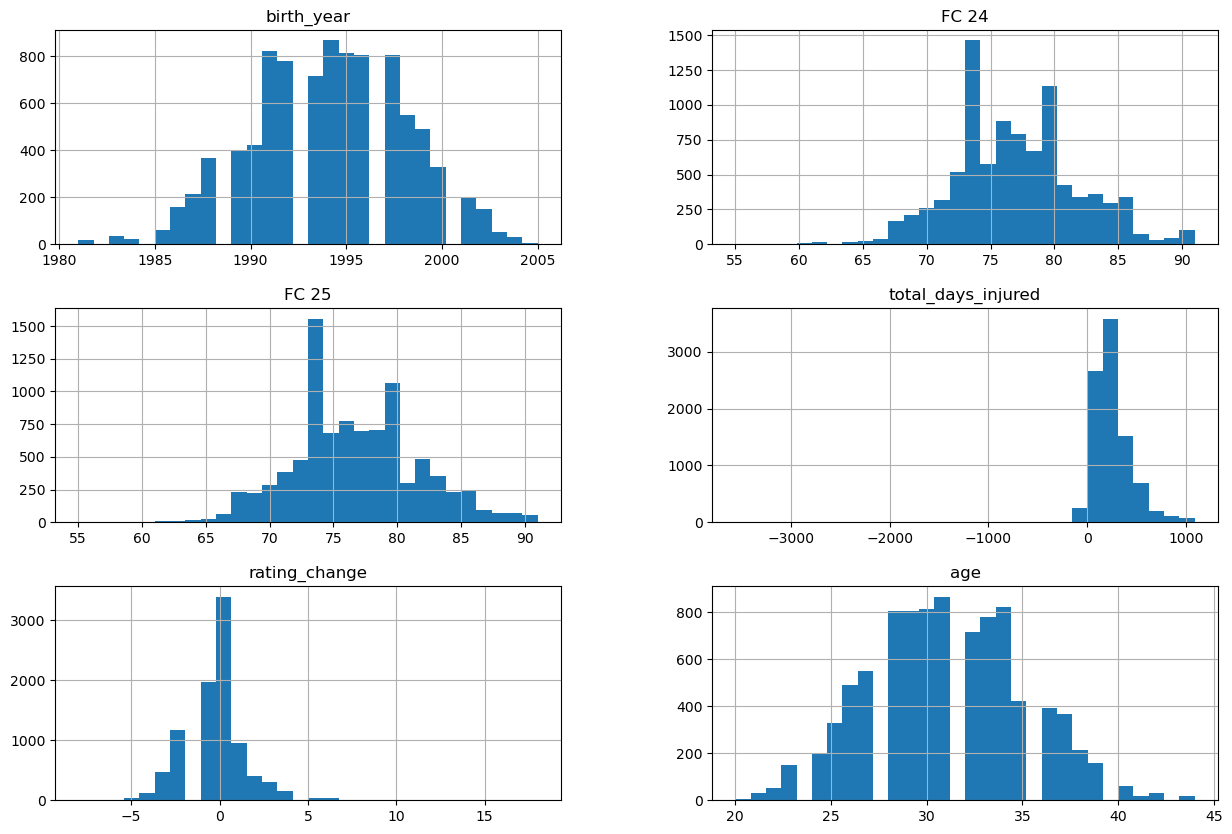

In [26]:
# Histograms
model_df.hist(bins=30, figsize=(15, 10))
plt.show()

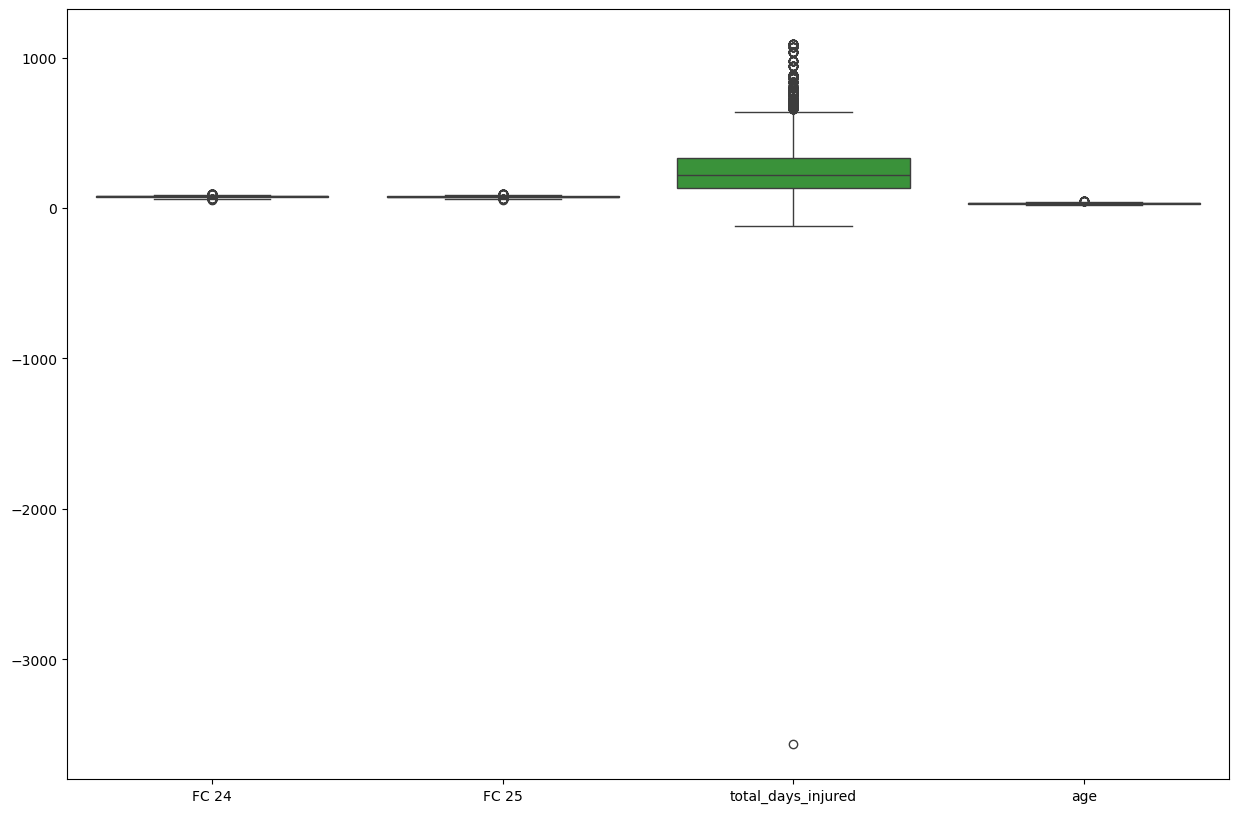

In [27]:
# Box plots for numerical features
plt.figure(figsize=(15, 10))
sns.boxplot(data=model_df[["FC 24", "FC 25", "total_days_injured", "age"]])
plt.show()

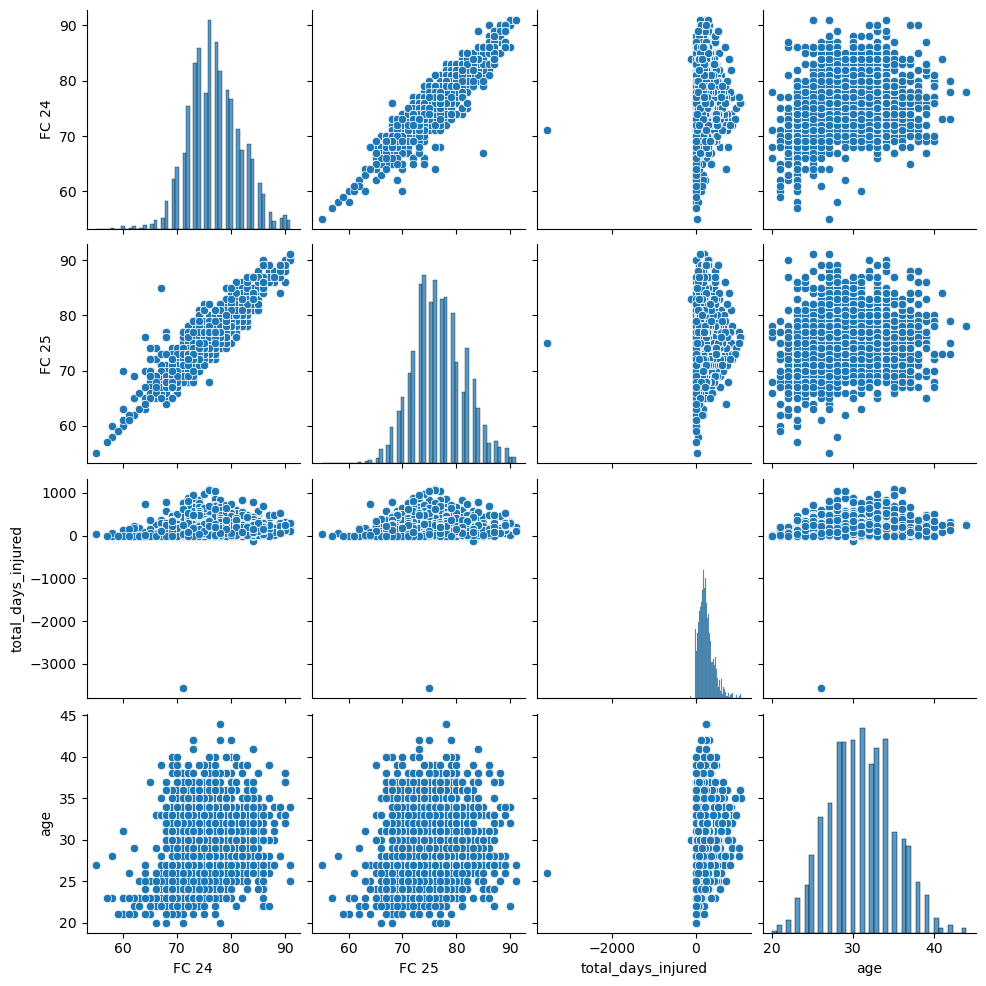

In [28]:
# Pair plots
sns.pairplot(model_df[["FC 24", "FC 25", "total_days_injured", "age"]])
plt.show()

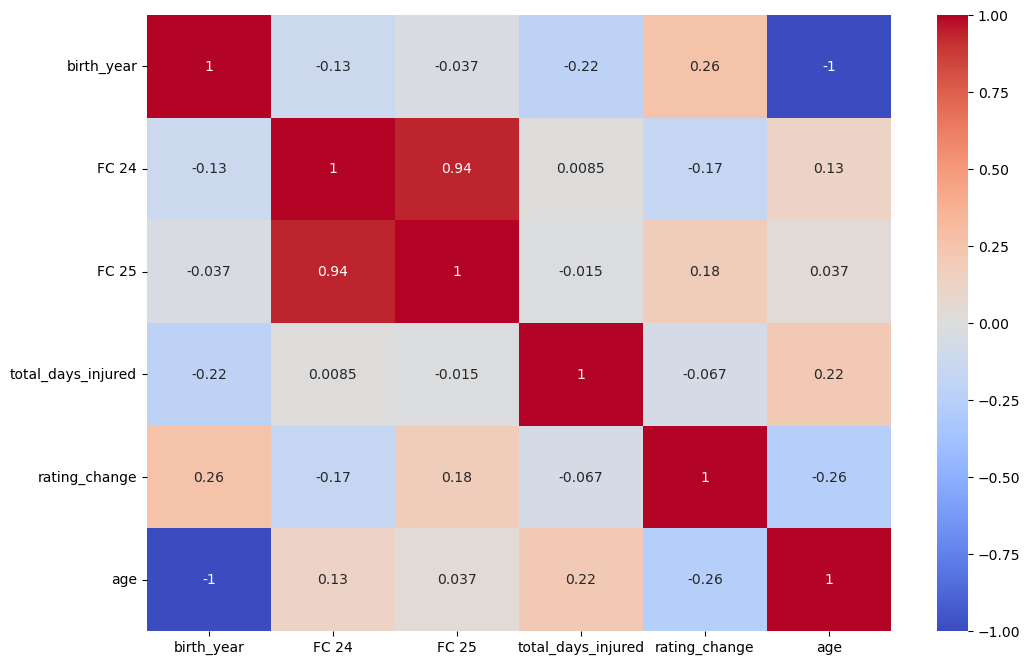

In [29]:
# Select only numeric columns
numeric_cols = model_df.select_dtypes(include=['number']).columns
corr_matrix = model_df[numeric_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Modeling

## Regression Models

In [31]:
# Define features and target
X = model_df.drop(columns=["name", "club_x", "birth_year", "FC 24", "FC 25", "rating_change"])
y = model_df["rating_change"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
print("R^2 score:", model.score(X_test, y_test))

R^2 score: 0.07528541507215347


### Random Forest Regressor

In [32]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
print("Random Forest R^2 score:", rf_model.score(X_test, y_test))

Random Forest R^2 score: 0.8281727549884175


### Decision Tree Regressor

In [33]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate
print("Decision Tree R^2 score:", dt_model.score(X_test, y_test))

Decision Tree R^2 score: 0.8130332731694648


### Gradient Boosting Regressor

In [34]:
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train, y_train)

print("R^2 score with Gradient Boosting Regression:", gbr_model.score(X_test, y_test))

R^2 score with Gradient Boosting Regression: 0.23300844400054743


## Classification Models

### Gradient Boosting Classifier

In [35]:
gbc_model = GradientBoostingClassifier(max_depth=6, random_state=42)
gbc_model.fit(X_train, y_train)

# Evaluate
print("Gradient Boosting R^2 score:", gbc_model.score(X_test, y_test))

y_pred_gbc = gbc_model.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_gbc)
print(f"Decision Tree Accuracy: {accuracy}")

# Classification Report
print(f"Classification Report:\n{classification_report(y_test, y_pred_gbc)}")

Gradient Boosting R^2 score: 0.9048927982407916
Decision Tree Accuracy: 0.9048927982407916
Classification Report:
              precision    recall  f1-score   support

        -8.0       1.00      1.00      1.00         1
        -5.0       0.80      1.00      0.89         4
        -4.0       0.95      0.86      0.90        21
        -3.0       0.99      0.86      0.92        97
        -2.0       0.97      0.85      0.91       263
        -1.0       0.92      0.90      0.91       399
         0.0       0.88      0.97      0.92       659
         1.0       0.89      0.85      0.87       185
         2.0       0.89      0.83      0.86        89
         3.0       0.88      0.94      0.91        53
         4.0       0.91      0.84      0.88        25
         5.0       0.80      0.80      0.80         5
         6.0       0.73      0.89      0.80         9
         7.0       0.00      0.00      0.00         2
         8.0       1.00      0.80      0.89         5
        10.0       0.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Decision Tree Classifier - FINAL Chosen Model for this Method

In [36]:
dtc_model = DecisionTreeClassifier(random_state=42)
dtc_model.fit(X_train, y_train)

print("Decision Tree R^2 score:", dtc_model.score(X_test, y_test))

y_pred_dtc = dtc_model.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_dtc)
print(f"Decision Tree Accuracy: {accuracy}")

# Classification Report
print(f"Classification Report:\n{classification_report(y_test, y_pred_dtc)}")

Decision Tree R^2 score: 0.9345794392523364
Decision Tree Accuracy: 0.9345794392523364
Classification Report:
              precision    recall  f1-score   support

        -8.0       1.00      1.00      1.00         1
        -5.0       0.80      1.00      0.89         4
        -4.0       0.86      0.86      0.86        21
        -3.0       0.99      0.88      0.93        97
        -2.0       0.94      0.93      0.94       263
        -1.0       0.93      0.95      0.94       399
         0.0       0.94      0.97      0.96       659
         1.0       0.93      0.89      0.91       185
         2.0       0.90      0.87      0.88        89
         3.0       0.85      0.96      0.90        53
         4.0       0.91      0.80      0.85        25
         5.0       0.80      0.80      0.80         5
         6.0       1.00      0.89      0.94         9
         7.0       0.00      0.00      0.00         2
         8.0       1.00      0.80      0.89         5
        10.0       0.00  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
